Building Mood Based Music Recommendation System using Spotify dataset and the Million Song Dataset
image.png

# 🎵 Music Recommendation System: Data Processing & Analysis

This notebook demonstrates how to load, explore, and preprocess datasets for a **music recommendation system**. The datasets are sourced from Kaggle and stored locally.

## 📂 Dataset Sources:
1. **Million Song Dataset** 🎶
2. **Spotify Dataset** 🎧
3. **User Behavior Analysis**
4. **Song Recommendation Data**

---


In [6]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import json
import nbformat
import tensorflow as tf
from tensorflow import keras
from bs4 import BeautifulSoup
from io import StringIO
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers import Dense, Dropout, Input
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, RobustScaler, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score
from tensorflow.keras.models import Sequential
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.utils.class_weight import compute_class_weight

# **Data preprocessing**

In [7]:
import os

for dirname, _, filenames in os.walk('/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS'):
    for filename in filenames:
        print(os.path.join(dirname, filename))




/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/.DS_Store
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/Untitled.ipynb
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/.DS_Store
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/.DS_Store
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/data_by_genres.csv
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/data.csv
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/data_by_artist.csv
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/data_by_year.csv
/Users/nchatterjee/Desktop/Berkley_ML/Modules/Recommendation_System/input/DATASETS/spotify-dataset/data/da

In [8]:
data_dirs = {
    "million_song": "input/million-song-dataset",
    "spotify_songs": "input/spotify-dataset",
    "million_song_studies": "input/million-song-dataset-studies",
    "spotify_user_behavior": "input/spotify-user-behavior-analysis",  # Integrated the Spotify User Behavior Analysis
    "spotify_song_prediction": "input/spotify-song-prediction-and-recommendation-system",
    "musics_demographic_data": "input/musics-depending-on-demographic-data"
}


## Extracting Datasets from CSV Files
## This function, load_specific_datasets(), is designed to load and aggregate datasets from different directories. It handles multiple datasets and performs checks to ensure that necessary files exist before loading them. The datasets include:

## Million Song Dataset (Test and Train): Expects two CSV files: one for training and one for testing.
## Million Song Dataset Studies: Combines multiple CSV files into one dataset.
## Spotify Dataset: Loads multiple CSV files, each representing a different aspect of the dataset.

In [9]:
def load_specific_datasets():
    datasets = {}

    # Million Song Dataset (Test and Train)
    million_song_files = list_files(data_dirs["million_song"])
    if "Testing_set_songs.csv" in million_song_files and "Training_set_songs.csv" in million_song_files:
        train_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Training_set_songs.csv"))
        test_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Testing_set_songs.csv"))
        datasets["million_song"] = {"train": train_data, "test": test_data}
    else:
        print("Error: Test or Train files not found in Million Song Dataset.")

    # Million Song Dataset Studies (Multiple files)
    studies_files = list_files(data_dirs["million_song_studies"])
    studies_data = []
    for file in studies_files:
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(data_dirs["million_song_studies"], file))
            studies_data.append(data)
    if studies_data:
        datasets["million_song_studies"] = pd.concat(studies_data, ignore_index=True)
    else:
        print("Error: No CSV files found in Million Song Dataset Studies.")

    # Spotify Dataset (Multiple files)
    spotify_files = list_files(data_dirs["spotify_songs"])
    spotify_data = {}
    for file in spotify_files:
        if file.endswith(".csv"):
            file_name = file.replace(".csv", "")
            spotify_data[file_name] = pd.read_csv(os.path.join(data_dirs["spotify_songs"], file))
    if spotify_data:
        datasets["spotify_songs"] = spotify_data
    else:
        print("Error: No CSV files found in Spotify Dataset.")

    return datasets

## Handling Missing Values in Datasets
## This section of code defines a function, handle_missing_values(), which is used to fill in missing data in a DataFrame. It then demonstrates how to apply this function to different datasets that were previously loaded.

Here is my data tree structure.  
/input/DATASETS/
    ├── million-song-dataset
    │   ├── Testing_set_songs.csv
    │   └── Training_set_songs.csv
    ├── million-song-dataset-studies
    │   ├── song_data1.csv
    │   ├── song_data2.csv
    │   ...
    └── spotify-dataset
        └── data
            ├── data_by_artist.csv
            ├── data_by_genres.csv
            ├── data_by_year.csv
            ├── data_w_genres.csv
            └── data.csv


In [10]:
import os
import pandas as pd
import logging

logging.basicConfig(level=logging.INFO)

def list_files(directory):
    try:
        return os.listdir(directory)
    except FileNotFoundError:
        logging.error(f"Directory not found: {directory}")
        return []

# Update data directories with the correct relative path from your working directory
data_dirs = {
    "million_song": "input/DATASETS/million-song-dataset",
    "million_song_studies": "input/DATASETS/million-song-dataset-studies",
    "spotify_songs": "input/DATASETS/spotify-dataset/data"
}

def load_specific_datasets():
    datasets = {}

    # Million Song Dataset (Test and Train)
    million_song_files = list_files(data_dirs["million_song"])
    if "Testing_set_songs.csv" in million_song_files and "Training_set_songs.csv" in million_song_files:
        train_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Training_set_songs.csv"))
        test_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Testing_set_songs.csv"))
        datasets["million_song"] = {"train": train_data, "test": test_data}
    else:
        logging.error("Error: Test or Train files not found in Million Song Dataset.")

    # Million Song Dataset Studies
    studies_files = list_files(data_dirs["million_song_studies"])
    studies_data = []
    for file in studies_files:
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(data_dirs["million_song_studies"], file))
            studies_data.append(data)
    if studies_data:
        datasets["million_song_studies"] = pd.concat(studies_data, ignore_index=True)
    else:
        logging.error("Error: No CSV files found in Million Song Dataset Studies.")

    # Spotify Dataset
    spotify_files = list_files(data_dirs["spotify_songs"])
    spotify_data = {}
    for file in spotify_files:
        if file.endswith(".csv"):
            file_name = file.replace(".csv", "")
            spotify_data[file_name] = pd.read_csv(os.path.join(data_dirs["spotify_songs"], file))
    if spotify_data:
        datasets["spotify"] = spotify_data
    else:
        logging.error("Error: No CSV files found in Spotify Dataset.")

    return datasets

def handle_missing_values(df, num_strategy="mean", cat_strategy="mode"):
    if not isinstance(df, pd.DataFrame):
        logging.error("Input must be a pandas DataFrame.")
        raise ValueError("Input must be a pandas DataFrame")
    
    logging.info("Missing values before handling:")
    logging.info(df.isnull().sum())

    df = df.copy()
    
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if num_strategy == "mean":
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    elif num_strategy == "median":
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
    else:
        logging.warning(f"Numeric strategy '{num_strategy}' not recognized. Using mean.")
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())
    
    categorical_cols = df.select_dtypes(exclude=['float64', 'int64']).columns
    for col in categorical_cols:
        if cat_strategy == "mode":
            mode_series = df[col].mode()
            fill_value = mode_series[0] if not mode_series.empty else "Unknown"
            df[col] = df[col].fillna(fill_value)
        elif cat_strategy == "constant":
            df[col] = df[col].fillna("Unknown")
        else:
            logging.warning(f"Categorical strategy '{cat_strategy}' not recognized. Using mode.")
            mode_series = df[col].mode()
            fill_value = mode_series[0] if not mode_series.empty else "Unknown"
            df[col] = df[col].fillna(fill_value)
    
    logging.info("Missing values after handling:")
    logging.info(df.isnull().sum())
    
    return df

# Example usage:
if __name__ == "__main__":
    all_datasets = load_specific_datasets()
    
    # Handle missing values for the Million Song Dataset (train & test splits)
    million_song_data = all_datasets.get("million_song")
    if million_song_data is not None:
        million_song_data["train"] = handle_missing_values(million_song_data["train"])
        million_song_data["test"] = handle_missing_values(million_song_data["test"])
    
    # Handle missing values for the Spotify Dataset (multiple files)
    spotify_data = all_datasets.get("spotify")
    if spotify_data is not None:
        for key, df in spotify_data.items():
            spotify_data[key] = handle_missing_values(df)
    
    # Handle missing values for the Million Song Studies Dataset
    million_song_studies = all_datasets.get("million_song_studies")
    if million_song_studies is not None:
        million_song_studies = handle_missing_values(million_song_studies)


INFO:root:Missing values before handling:
INFO:root:Year    0
TA01    0
TA02    0
TA03    0
TA04    0
       ..
TC74    0
TC75    0
TC76    0
TC77    0
TC78    0
Length: 91, dtype: int64
INFO:root:Missing values after handling:
INFO:root:Year    0
TA01    0
TA02    0
TA03    0
TA04    0
       ..
TC74    0
TC75    0
TC76    0
TC77    0
TC78    0
Length: 91, dtype: int64
INFO:root:Missing values before handling:
INFO:root:TA01    0
TA02    0
TA03    0
TA04    0
TA05    0
       ..
TC74    0
TC75    0
TC76    0
TC77    0
TC78    0
Length: 90, dtype: int64
INFO:root:Missing values after handling:
INFO:root:TA01    0
TA02    0
TA03    0
TA04    0
TA05    0
       ..
TC74    0
TC75    0
TC76    0
TC77    0
TC78    0
Length: 90, dtype: int64
INFO:root:Missing values before handling:
INFO:root:mode                0
genres              0
acousticness        0
danceability        0
duration_ms         0
energy              0
instrumentalness    0
liveness            0
loudness            0
spee

## Normalizing Features with MinMaxScaler
## This code block defines a function normalize_features() that normalizes numerical columns in a Pandas DataFrame using scikit-learn’s MinMaxScaler. The function works as follows:

## Input Checking and Copying:
It first verifies that the DataFrame is not None and then creates a copy of it to avoid modifying the original data.

## Column Selection:
If no specific columns are provided, the function automatically selects all numerical columns (i.e. columns with data types int64 or float64).

## Normalization:
The function then applies MinMaxScaler to the selected columns, scaling their values to a range between 0 and 1.

## Return Value:
Finally, the function returns the normalized DataFrame.

In [11]:
import logging
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

def normalize_features(df, columns=None, scaler=None):
    """
    Normalize the numeric features in a DataFrame using MinMax scaling.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to normalize.
        columns (list, optional): A list of columns to normalize. If None, all numeric columns are used.
        scaler (sklearn.preprocessing.MinMaxScaler, optional): A pre-created scaler. If None, a new one is created.
        
    Returns:
        pd.DataFrame: A new DataFrame with normalized columns.
    """
    if df is None:
        logging.error("DataFrame is None.")
        return None

    # Use the provided scaler or create a new one
    if scaler is None:
        scaler = MinMaxScaler()

    # Create a copy to avoid modifying the original DataFrame
    df = df.copy()

    # If no columns are specified, select all numerical columns
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    # Select only the columns that exist in the DataFrame
    available_columns = [col for col in columns if col in df.columns]
    if not available_columns:
        logging.warning(f"No matching columns found for normalization. DataFrame columns: {df.columns.tolist()}")
        return df

    # Normalize the selected columns and catch potential errors
    try:
        df[available_columns] = scaler.fit_transform(df[available_columns])
    except Exception as e:
        logging.error(f"Normalization failed: {e}")
        return df

    return df

# Example Usage:
if __name__ == "__main__":
    # Normalize Million Song Dataset (Train & Test splits)
    if "million_song" in all_datasets and all_datasets["million_song"]:
        million_song_data = all_datasets["million_song"]
        million_song_data["train"] = normalize_features(million_song_data["train"])
        million_song_data["test"] = normalize_features(million_song_data["test"])

    # Normalize Spotify Dataset (multiple files)
    if "spotify" in all_datasets and all_datasets["spotify"]:
        spotify_data = all_datasets["spotify"]
        for key, df in spotify_data.items():
            spotify_data[key] = normalize_features(df)

    # Normalize Million Song Studies Dataset
    if "million_song_studies" in all_datasets and all_datasets["million_song_studies"] is not None:
        million_song_studies = all_datasets["million_song_studies"]
        million_song_studies = normalize_features(million_song_studies)


## Encoding Categorical Features with LabelEncoder
This code block defines a function called encode_categorical_features() that:

Checks the Input:
Verifies that the provided DataFrame is not None. If it is, the function logs an error and returns a default value.

Identifies Categorical Columns:
Selects columns with data types 'object' or 'category' as categorical features. It logs the detected columns.

Encodes Each Categorical Column:
Uses scikit-learn’s LabelEncoder to convert categorical values into numeric labels. The function stores each encoder in a dictionary so you can later inverse-transform if needed.

Returns:
A tuple containing the transformed DataFrame and the dictionary of label encoders.

The rest of the code loads various datasets, applies feature normalization (with the normalize_features() function defined previously), and then encodes categorical features for each dataset.

In [12]:
import logging
from sklearn.preprocessing import LabelEncoder  # For label encoding categorical features
import pandas as pd

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

def encode_categorical_features(df: pd.DataFrame) -> (pd.DataFrame, dict):
    """
    Encode categorical features in a DataFrame using LabelEncoder.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame. Must not be None.
        
    Returns:
        tuple: A tuple (df_encoded, label_encoders) where:
            - df_encoded (pd.DataFrame): The DataFrame with categorical columns encoded.
            - label_encoders (dict): A dictionary mapping column names to their respective LabelEncoder objects.
    """
    if df is None:
        logging.error("DataFrame is None.")
        return None, {}

    df = df.copy()
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    logging.info(f"Detected categorical columns for encoding: {categorical_columns}")

    label_encoders = {}
    for col in categorical_columns:
        try:
            le = LabelEncoder()
            # If you prefer One Hot Encoding, you can instead use pandas.get_dummies() or sklearn's OneHotEncoder.
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le
            logging.info(f"Encoded column: {col}")
        except Exception as e:
            logging.error(f"Failed to encode column {col}: {e}")

    return df, label_encoders

# If you want load_specific_datasets to accept data_dirs, modify its signature:
def load_specific_datasets(data_dirs: dict) -> dict:
    """
    Load datasets from specified directories.
    
    Parameters:
        data_dirs (dict): A dictionary mapping dataset keys to their directory paths.
    
    Returns:
        dict: A dictionary of datasets.
    """
    datasets = {}

    # Million Song Dataset (Test and Train)
    million_song_files = list_files(data_dirs["million_song"])
    if "Testing_set_songs.csv" in million_song_files and "Training_set_songs.csv" in million_song_files:
        train_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Training_set_songs.csv"))
        test_data = pd.read_csv(os.path.join(data_dirs["million_song"], "Testing_set_songs.csv"))
        datasets["million_song"] = {"train": train_data, "test": test_data}
    else:
        logging.error("Error: Test or Train files not found in Million Song Dataset.")

    # Million Song Dataset Studies
    studies_files = list_files(data_dirs["million_song_studies"])
    studies_data = []
    for file in studies_files:
        if file.endswith(".csv"):
            data = pd.read_csv(os.path.join(data_dirs["million_song_studies"], file))
            studies_data.append(data)
    if studies_data:
        datasets["million_song_studies"] = pd.concat(studies_data, ignore_index=True)
    else:
        logging.error("Error: No CSV files found in Million Song Dataset Studies.")

    # Spotify Dataset (assuming key "spotify_songs" here)
    spotify_files = list_files(data_dirs["spotify_songs"])
    spotify_data = {}
    for file in spotify_files:
        if file.endswith(".csv"):
            file_name = file.replace(".csv", "")
            spotify_data[file_name] = pd.read_csv(os.path.join(data_dirs["spotify_songs"], file))
    if spotify_data:
        datasets["spotify_songs"] = spotify_data
    else:
        logging.error("Error: No CSV files found in Spotify Dataset.")

    # Optionally, add more datasets if needed
    # e.g., spotify_user_behavior dataset can be added here

    return datasets

# Example usage:
# Define your data directories relative to your working directory
data_dirs = {
    "million_song": "input/DATASETS/million-song-dataset",
    "million_song_studies": "input/DATASETS/million-song-dataset-studies",
    "spotify_songs": "input/DATASETS/spotify-dataset/data",
    # "spotify_user_behavior": "input/DATASETS/spotify-user-behavior"  # Uncomment if available
}

# Load all datasets (now passing data_dirs as argument)
all_datasets = load_specific_datasets(data_dirs)

# Normalize datasets (using the previously defined normalize_features function)
if "million_song" in all_datasets and all_datasets["million_song"]:
    million_song_data = all_datasets["million_song"]
    million_song_data["train"] = normalize_features(million_song_data["train"])
    million_song_data["test"] = normalize_features(million_song_data["test"])

if "spotify_songs" in all_datasets and all_datasets["spotify_songs"]:
    spotify_data = all_datasets["spotify_songs"]
    for key, df in spotify_data.items():
        spotify_data[key] = normalize_features(df)

if "million_song_studies" in all_datasets and all_datasets["million_song_studies"] is not None:
    million_song_studies = all_datasets["million_song_studies"]
    million_song_studies = normalize_features(million_song_studies)

# Optionally, if you have spotify_user_behavior, normalize it too
# if "spotify_user_behavior" in all_datasets and all_datasets["spotify_user_behavior"] is not None:
#     spotify_user_behavior = normalize_features(all_datasets["spotify_user_behavior"])

# Encode Categorical Features
if million_song_data is not None:
    logging.info("Encoding Million Song Train DataFrame:")
    million_song_data["train"], million_song_label_encoders = encode_categorical_features(million_song_data["train"])
    logging.info("Encoding Million Song Test DataFrame:")
    million_song_data["test"], _ = encode_categorical_features(million_song_data["test"])

if spotify_data is not None:
    for key, df in spotify_data.items():
        logging.info(f"Encoding Spotify DataFrame: {key}")
        spotify_data[key], spotify_label_encoders = encode_categorical_features(df)

if million_song_studies is not None:
    logging.info("Encoding Million Song Studies DataFrame:")
    million_song_studies, million_song_studies_encoders = encode_categorical_features(million_song_studies)

# If spotify_user_behavior is available, encode it similarly:
# if spotify_user_behavior is not None:
#     logging.info("Encoding Spotify User Behavior DataFrame:")
#     spotify_user_behavior, spotify_user_behavior_encoders = encode_categorical_features(spotify_user_behavior)


INFO:root:Encoding Million Song Train DataFrame:
INFO:root:Detected categorical columns for encoding: []
INFO:root:Encoding Million Song Test DataFrame:
INFO:root:Detected categorical columns for encoding: []
INFO:root:Encoding Spotify DataFrame: data_by_genres
INFO:root:Detected categorical columns for encoding: ['genres']
INFO:root:Encoded column: genres
INFO:root:Encoding Spotify DataFrame: data
INFO:root:Detected categorical columns for encoding: ['artists', 'id', 'name', 'release_date']
INFO:root:Encoded column: artists
INFO:root:Encoded column: id
INFO:root:Encoded column: name
INFO:root:Encoded column: release_date
INFO:root:Encoding Spotify DataFrame: data_by_artist
INFO:root:Detected categorical columns for encoding: ['artists']
INFO:root:Encoded column: artists
INFO:root:Encoding Spotify DataFrame: data_by_year
INFO:root:Detected categorical columns for encoding: []
INFO:root:Encoding Spotify DataFrame: data_w_genres
INFO:root:Detected categorical columns for encoding: ['genr

# *Exploratory Data Analysis (EDA): 
Combining & Filtering Music Features
This code block is designed to prepare data for exploratory data analysis on music-related datasets. It performs the following tasks:

Suppress Warnings:
Suppresses FutureWarning messages to keep the output clean.

Define Music Features:
A list of key music-related features (e.g., duration, key, tempo, etc.) is specified. These are the columns we want to analyze.

Combine Data:
The function combine_numerical_data() is defined to merge multiple datasets into one DataFrame.

It loops over each dataset (handling both simple DataFrames and those split into sub-dictionaries, like train/test splits) and concatenates them into a single DataFrame.
Filter for Selected Features:
The combined dataset is filtered to include only the music-related features that are available.

Convert Columns to Numeric:
Finally, the code converts all columns in the filtered DataFrame to numeric values (coercing errors to NaN) to ensure that subsequent numerical analyses will work properly.

In [13]:
##EDA##
##Data Prep##

import warnings
import pandas as pd
import logging
import matplotlib.pyplot as plt
import seaborn as sns

# Set up logging configuration
logging.basicConfig(level=logging.INFO)

# Suppress FutureWarnings and RuntimeWarnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Selected music-related features
music_features = [
    'duration', 'key', 'tempo', 'time_signature', 'end_of_fade_in',
    'start_of_fade_out', 'loudness'
]

def combine_numerical_data(datasets: dict) -> pd.DataFrame:
    """
    Combine numerical data from multiple datasets into a single DataFrame.

    Parameters:
        datasets (dict): A dictionary containing datasets. Some values might be 
                         dictionaries (e.g., with train/test splits) or DataFrames.

    Returns:
        pd.DataFrame: The concatenated DataFrame containing all the data.
    """
    dataframes = []
    for key, data in datasets.items():
        if isinstance(data, dict):  # Handle datasets with train/test split
            for sub_key, df in data.items():
                if isinstance(df, pd.DataFrame):
                    dataframes.append(df)
        elif isinstance(data, pd.DataFrame):
            dataframes.append(data)
    
    if dataframes:
        combined_data = pd.concat(dataframes, ignore_index=True)
        return combined_data
    else:
        logging.warning("No DataFrames were found to combine.")
        return pd.DataFrame()

# Load and combine all datasets (using updated data_dirs)
all_datasets = load_specific_datasets(data_dirs)
combined_data = combine_numerical_data(all_datasets)

# Filter combined_data to include only the selected music features
available_music_features = [feature for feature in music_features if feature in combined_data.columns]
if not available_music_features:
    logging.error("None of the selected music features are present in the combined data.")
else:
    logging.info(f"Available music features for analysis: {available_music_features}")
music_data = combined_data[available_music_features]

# Convert columns to numeric where possible
for col in music_data.columns:
    music_data[col] = pd.to_numeric(music_data[col], errors='coerce')



INFO:root:Available music features for analysis: ['duration', 'key', 'tempo', 'time_signature', 'end_of_fade_in', 'start_of_fade_out', 'loudness']
/var/folders/88/z1ln_47j1rs8y53fy8q278s00000gn/T/ipykernel_78997/1205638617.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_data[col] = pd.to_numeric(music_data[col], errors='coerce')


## Basic Statistics and Visualization
1. Summary Statistics
A summary table (using describe()) is printed to display key statistics (mean, median, standard deviation, etc.) for the selected features.
This table helps in understanding the central tendency and spread of each feature.
2. Pairplot
A pairplot (using Seaborn) is generated for the key numerical features.
Improvement Suggestion:
Limit the number of features in the pairplot if there are many variables.
Ensure the pairplot includes clear titles and labels.
3. Feature Distributions
Histograms with KDE (kernel density estimate) overlays are plotted for each feature.
Improvement Suggestion:
Consider using subplots to display multiple histograms in one figure for better comparison.
Add descriptive titles and axis labels to improve readability.
4. Correlation Analysis
A correlation matrix is computed and visualized as a heatmap.
Improvement Suggestion:
Use larger fonts or rotate axis tick labels if the feature names are long.
Ensure the heatmap includes a clear title and color bar to indicate correlation strength.
5. Distribution of Representative Features

INFO:root:Summary Statistics:


Summary Statistics:
           duration            key          tempo  time_signature  \
count  20000.000000  251086.000000  251086.000000    10000.000000   
mean     238.507518       5.262778     117.136732        3.564800   
std      114.134660       3.510645      29.817848        1.266239   
min        1.044440       0.000000       0.000000        0.000000   
25%      176.032200       2.000000      95.172250        3.000000   
50%      223.059140       5.000000     115.336000        4.000000   
75%      276.375060       8.000000     134.290750        4.000000   
max     1819.767710      11.000000     262.828000        7.000000   

       end_of_fade_in  start_of_fade_out       loudness  
count    10000.000000       10000.000000  241086.000000  
mean         0.758616         229.975465     -11.337719  
std          1.867952         112.195735       5.704018  
min          0.000000           1.044000     -60.000000  
25%          0.000000         168.856000     -14.397000  
50%       

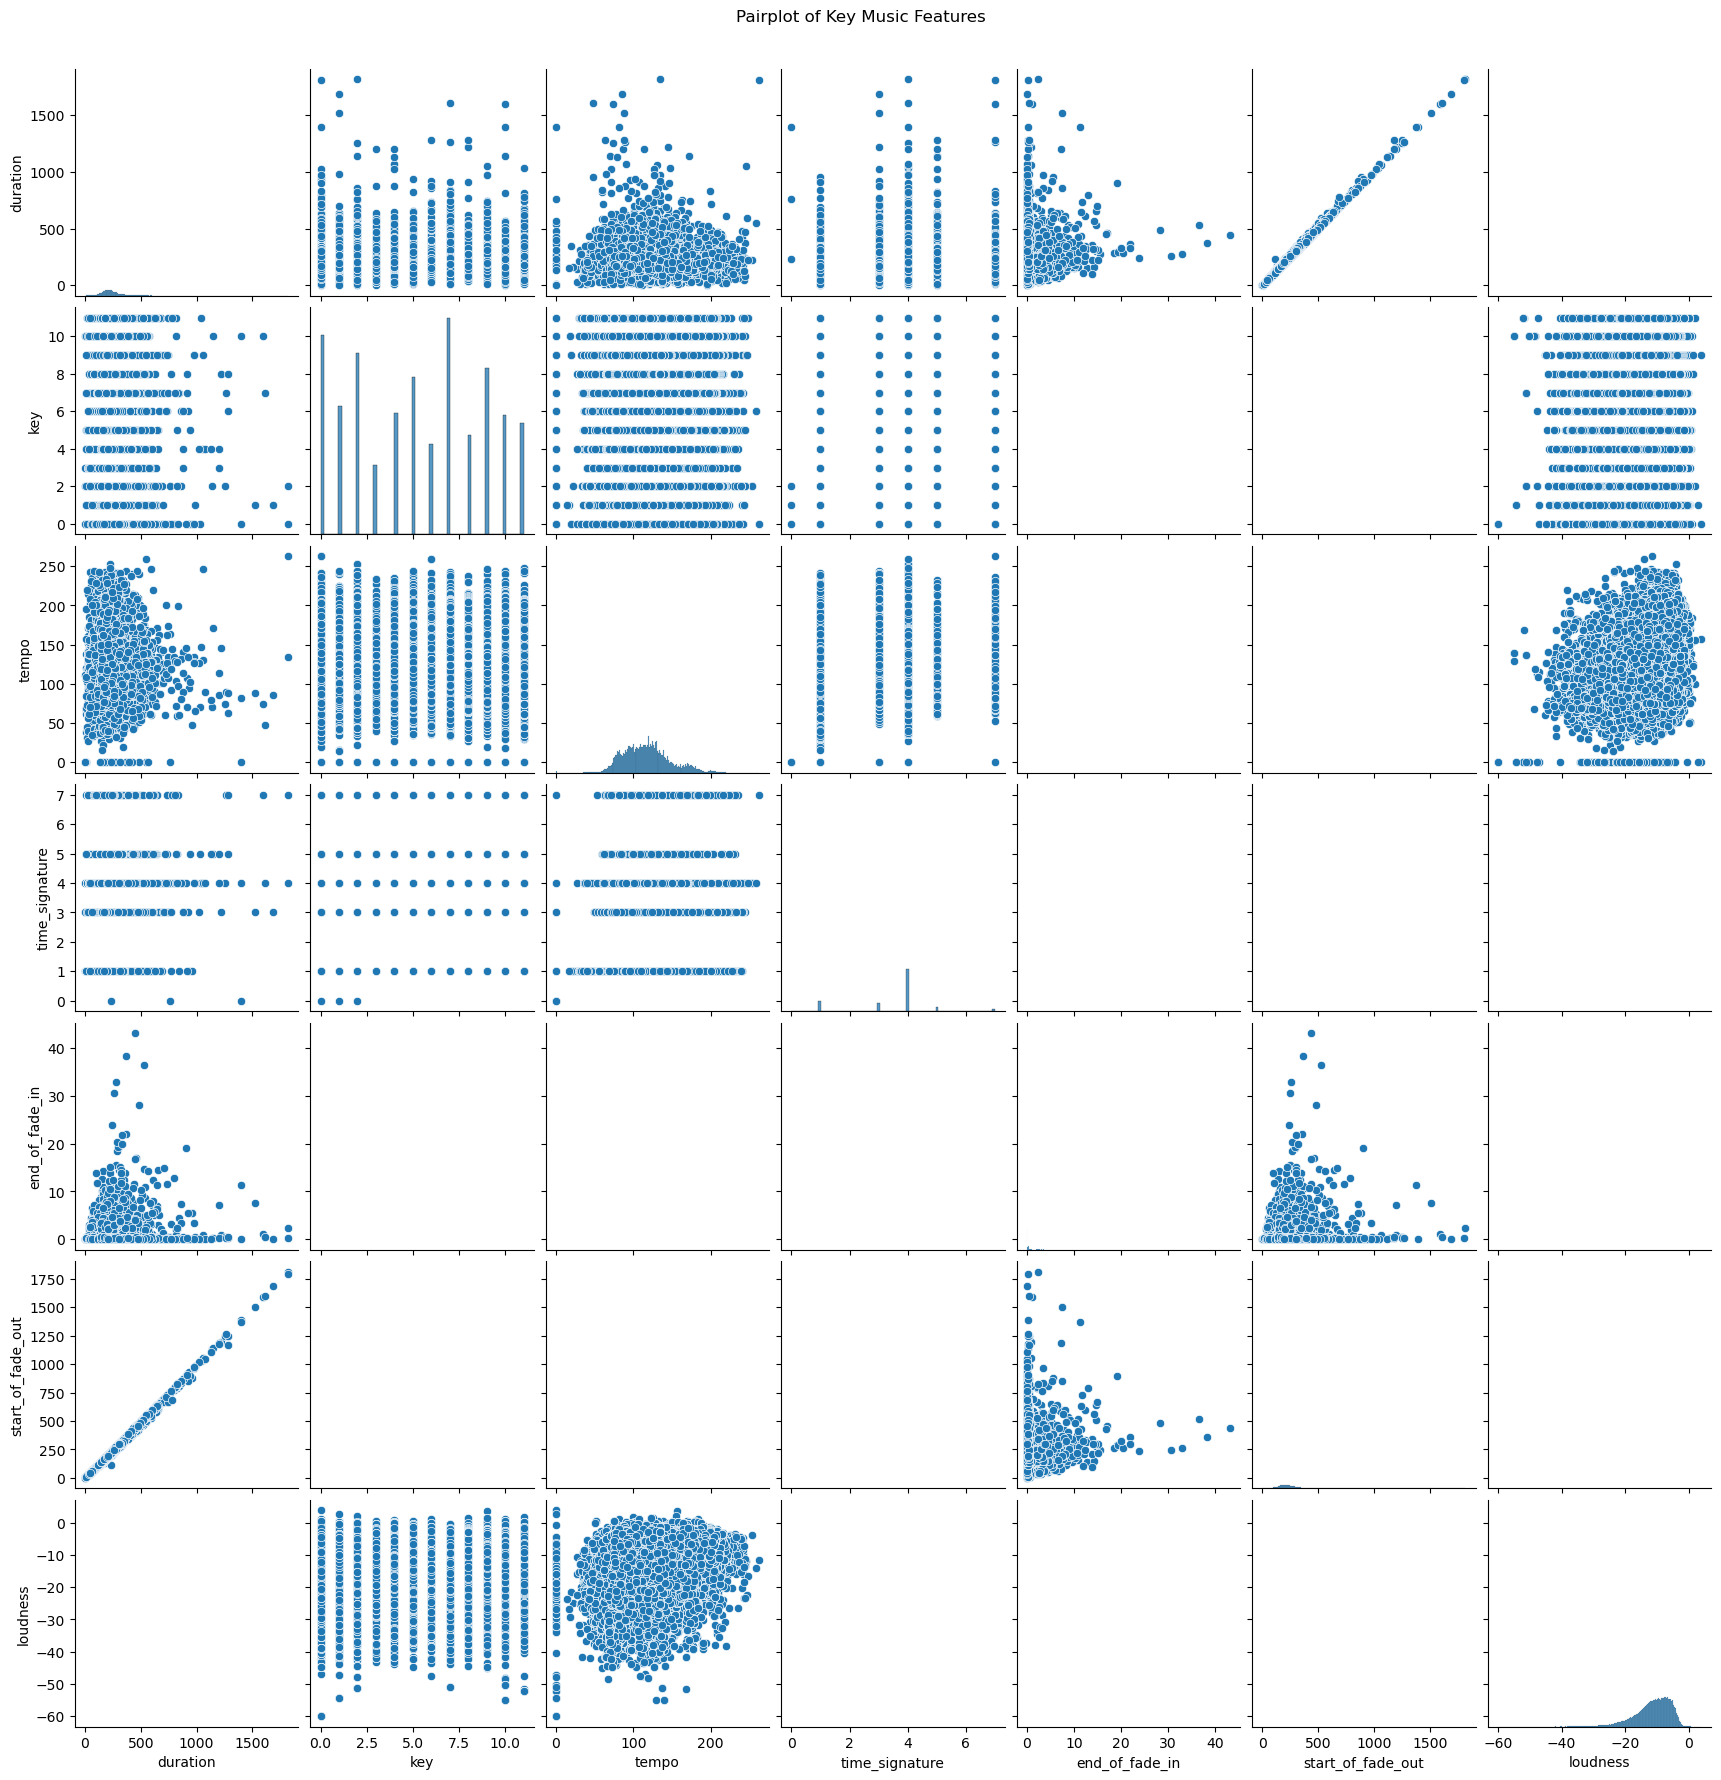

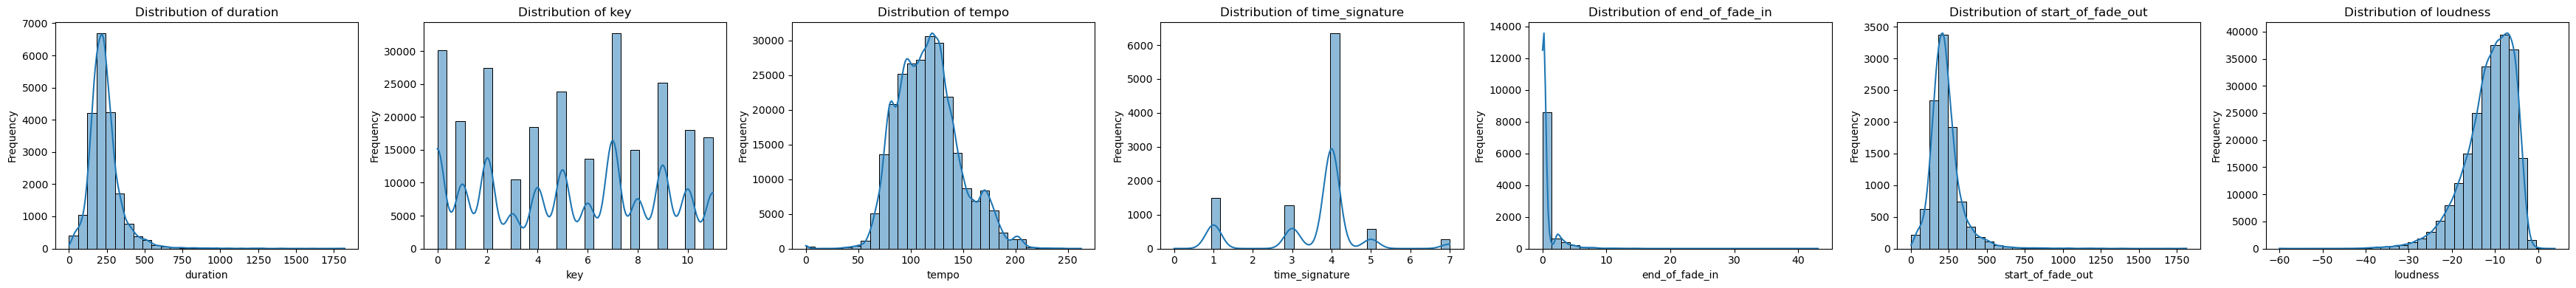

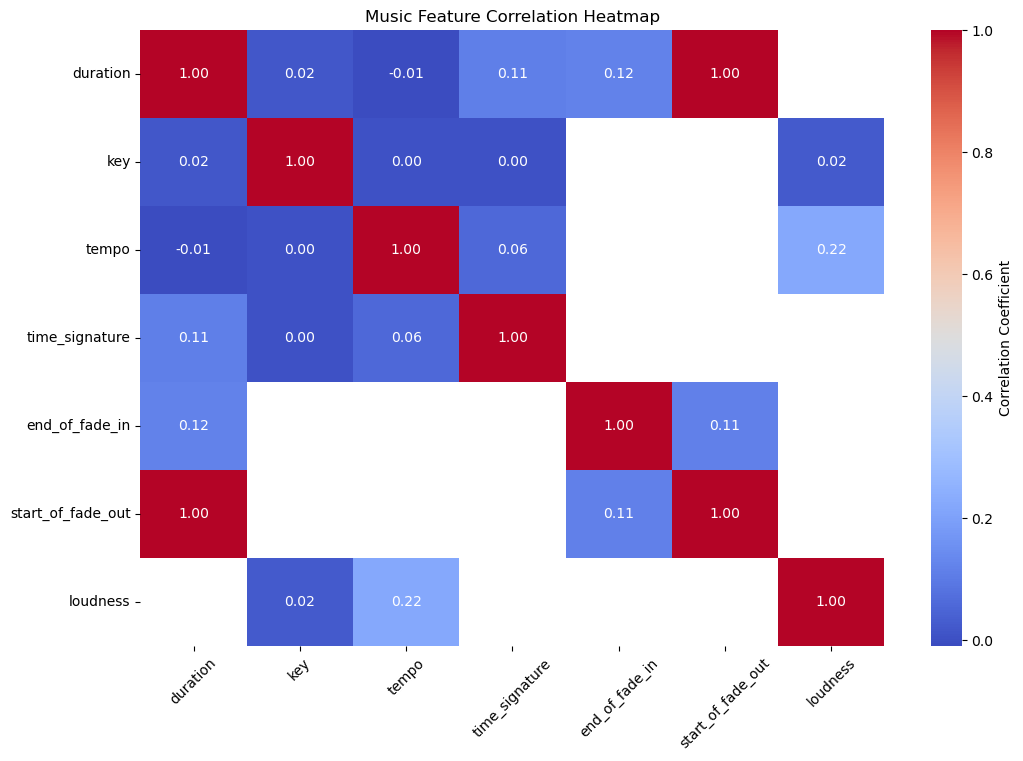

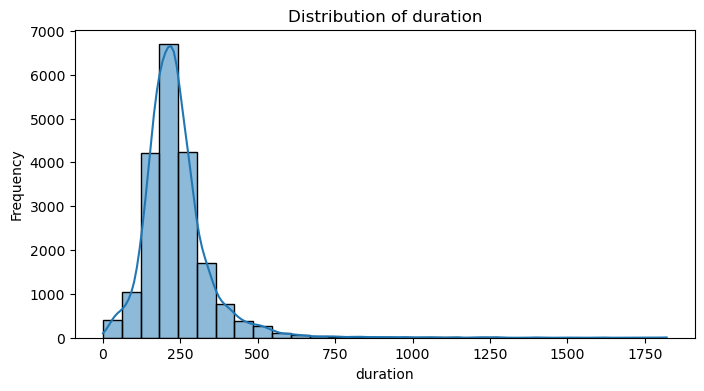

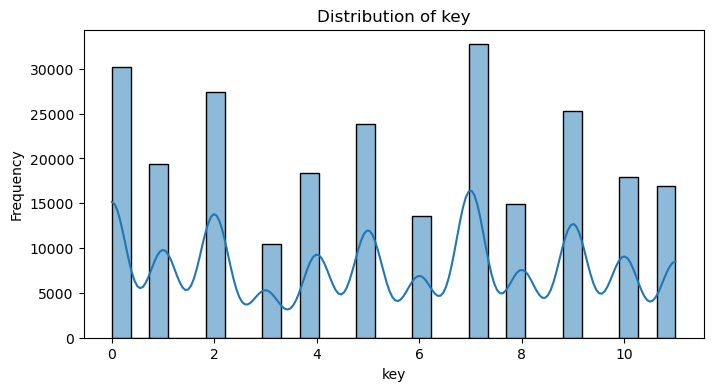

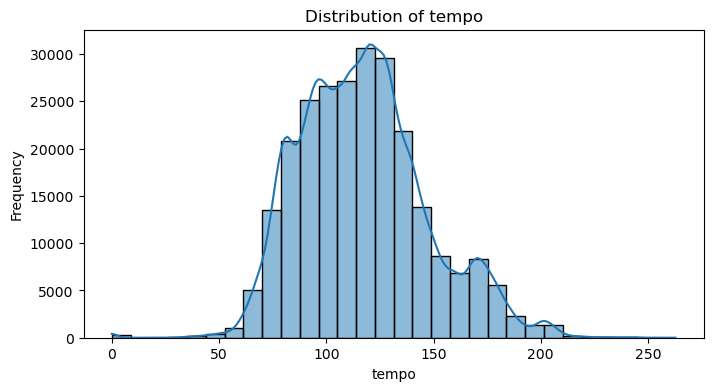

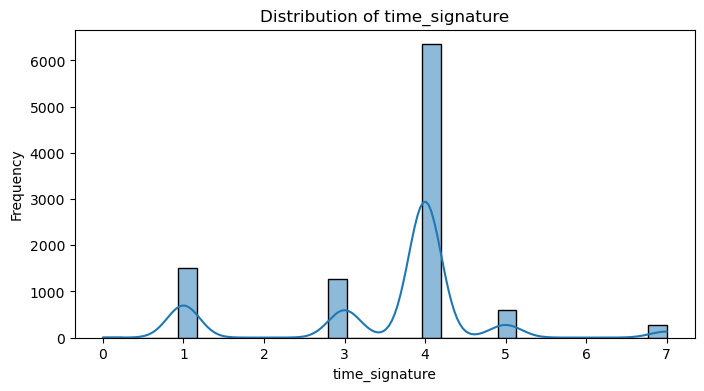

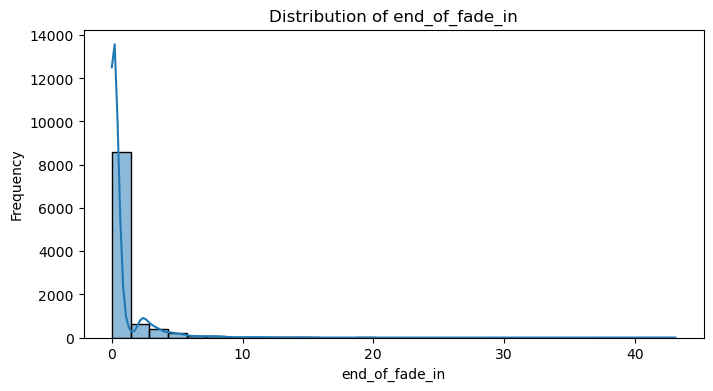

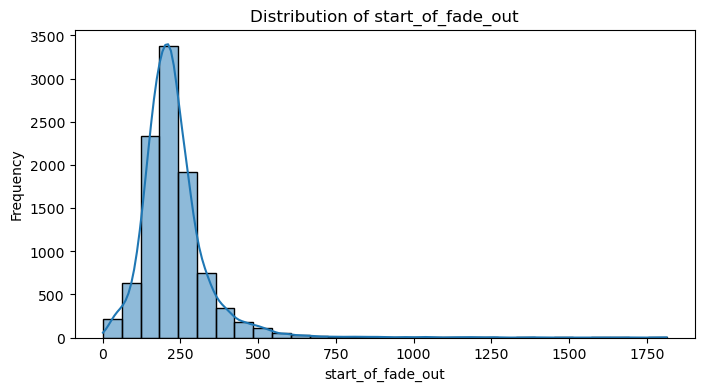

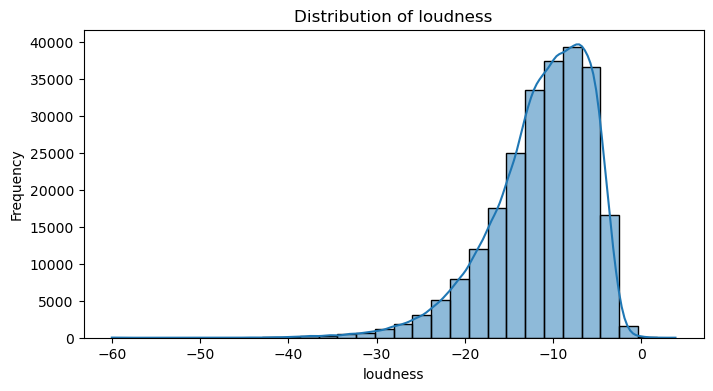

In [14]:
# ---------------------------
# Exploratory Data Analysis
# ---------------------------

## 1. Summary Statistics
summary_stats = music_data.describe()
logging.info("Summary Statistics:")
print("Summary Statistics:")
print(summary_stats)

## 2. Pairplot for Key Numerical Features
# Select up to the first 7 numerical features for pairplot (adjust as necessary)
key_features = music_data.select_dtypes(include=['float64', 'int64']).columns[:7]
sns.pairplot(music_data[key_features])
plt.suptitle("Pairplot of Key Music Features", y=1.02)
plt.show()

## 3. Distribution of Representative Features
# Create subplots for distribution plots to improve readability
num_features = len(key_features)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(5*num_features, 4))
for ax, feature in zip(axes, key_features):
    sns.histplot(music_data[feature].dropna(), bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

## 4. Correlation Matrix and Heatmap
correlation_matrix = music_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Music Feature Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()


## 5. Distribution of representative features
for feature in key_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(music_data[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()


# *Kmeans clustering*

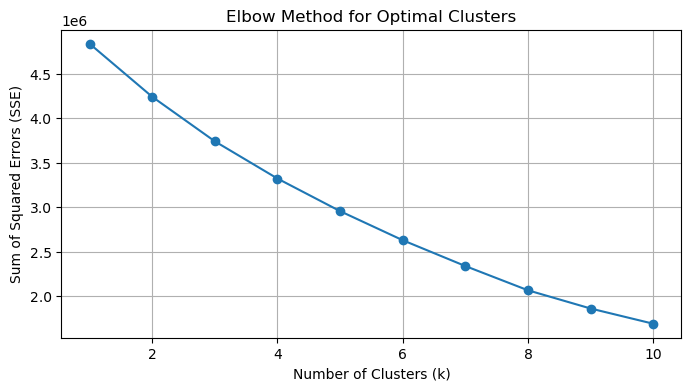

INFO:root:Cluster Centroids:
INFO:root:Sample Clustered Data:


     duration       key       tempo  time_signature  end_of_fade_in  \
0  238.208854  5.262914  117.132748        3.569477        0.756829   
1  523.498139  5.224622  117.244090        3.639761        2.160572   
2  203.714408  5.216054  119.205558        0.998662        0.758616   

   start_of_fade_out  
0         229.707681  
1         439.998938  
2         229.975465  
     duration       tempo       key  Cluster Cluster_Label
0  238.507518  117.136732  5.262778        0          jazz
1  238.507518  117.136732  5.262778        0          jazz
2  238.507518  117.136732  5.262778        0          jazz
3  238.507518  117.136732  5.262778        0          jazz
4  238.507518  117.136732  5.262778        0          jazz


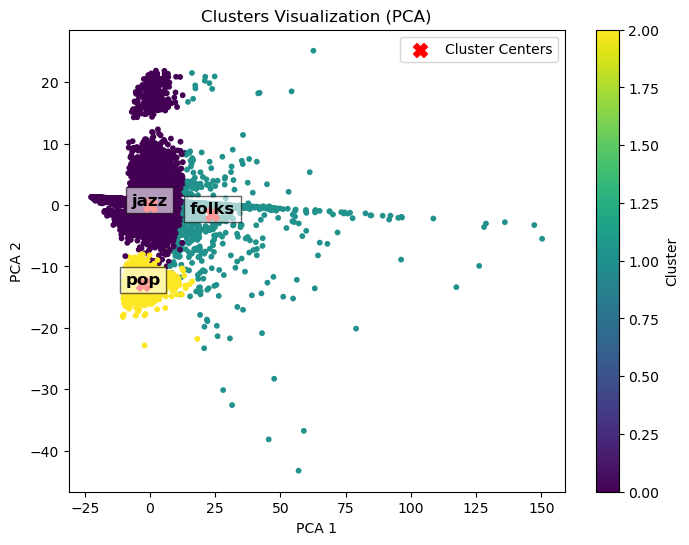

Clustered dataset saved as clustered_songs.csv


In [15]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import logging

# Setup logging and warnings
logging.basicConfig(level=logging.INFO)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Define music features for clustering as a constant
MUSIC_FEATURES = ['duration', 'key', 'tempo', 'time_signature', 'end_of_fade_in', 'start_of_fade_out']

def preprocess_data(music_data: pd.DataFrame, features: list) -> (pd.DataFrame, any, StandardScaler):
    """
    Preprocess the music data by filling missing values and scaling the selected features.
    
    Parameters:
        music_data (pd.DataFrame): DataFrame containing music data.
        features (list): List of feature names to preprocess.
        
    Returns:
        tuple: (df_cleaned, scaled_features, scaler)
            - df_cleaned: DataFrame after missing value imputation.
            - scaled_features: Numpy array of scaled feature values.
            - scaler: Fitted StandardScaler object.
    """
    df_cleaned = music_data.copy()
    # Fill missing values with mean (for numeric columns)
    for col in features:
        if df_cleaned[col].dtype in ['float64', 'int64']:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mean())
        else:
            # If any non-numeric columns exist, fill with mode
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])
    
    # Scale features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df_cleaned[features])
    return df_cleaned, scaled_features, scaler

def determine_optimal_clusters(scaled_features, k_range=range(1, 11)):
    """
    Compute SSE for a range of cluster numbers and return the SSE values.
    
    Parameters:
        scaled_features (array): Scaled feature array.
        k_range (iterable): Range of cluster numbers to evaluate.
    
    Returns:
        list: SSE values for each k in k_range.
    """
    sse = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(scaled_features)
        sse.append(kmeans.inertia_)
    return sse

def visualize_elbow(sse, k_range):
    """
    Plot the SSE values to visualize the elbow method.
    """
    plt.figure(figsize=(8, 4))
    plt.plot(list(k_range), sse, marker='o')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Sum of Squared Errors (SSE)')
    plt.title('Elbow Method for Optimal Clusters')
    plt.grid(True)
    plt.show()

def label_cluster_by_centroid(centroid, centroids):
    """
    Assign a label to a cluster based on its centroid features.
    
    Parameters:
        centroid (pd.Series): Centroid of the cluster.
        centroids (pd.DataFrame): DataFrame containing all centroids.
    
    Returns:
        str: Label for the cluster.
    """
    tempo_threshold = centroids['tempo'].quantile(0.75)
    fade_out_threshold = centroids['start_of_fade_out'].quantile(0.75)
    
    if centroid['start_of_fade_out'] >= fade_out_threshold:
        return "folks"  # Indicative of tracks with long fade-out, relaxed style
    elif centroid['tempo'] >= tempo_threshold:
        return "pop"    # High tempo may indicate energetic pop tracks
    else:
        return "jazz"   # Otherwise, a relaxed or jazzy mood

def perform_clustering(df_cleaned: pd.DataFrame, scaled_features, features: list, optimal_k: int = 3):
    """
    Perform KMeans clustering on the scaled features, assign cluster labels, and return the results.
    
    Parameters:
        df_cleaned (pd.DataFrame): Preprocessed DataFrame.
        scaled_features (array): Scaled features.
        features (list): List of features used for clustering.
        optimal_k (int): Number of clusters to form.
    
    Returns:
        tuple: (df_cleaned, centroids, cluster_labels, kmeans)
            - df_cleaned: DataFrame with assigned clusters and labels.
            - centroids: DataFrame of cluster centroids in original scale.
            - cluster_labels: Dictionary mapping cluster index to label.
            - kmeans: Fitted KMeans model.
    """
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(scaled_features)
    df_cleaned['Cluster'] = clusters
    
    # Inverse transform to get centroids in original scale
    centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
    cluster_labels = {i: label_cluster_by_centroid(centroids.iloc[i], centroids) for i in range(optimal_k)}
    df_cleaned['Cluster_Label'] = df_cleaned['Cluster'].map(cluster_labels)
    
    return df_cleaned, centroids, cluster_labels, kmeans

def visualize_clusters(df_cleaned: pd.DataFrame, kmeans, scaled_features, cluster_labels: dict):
    """
    Visualize the clusters using PCA for dimensionality reduction.
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(scaled_features)
    df_cleaned['PCA1'] = pca_result[:, 0]
    df_cleaned['PCA2'] = pca_result[:, 1]
    
    cluster_centers_pca = pca.transform(kmeans.cluster_centers_)
    
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(df_cleaned['PCA1'], df_cleaned['PCA2'], c=df_cleaned['Cluster'], cmap='viridis', s=10)
    plt.scatter(cluster_centers_pca[:, 0], cluster_centers_pca[:, 1], c='red', marker='X', s=100, label='Cluster Centers')
    
    for i, (x, y) in enumerate(cluster_centers_pca):
        label = cluster_labels.get(i, f"Cluster {i}")
        plt.text(x, y, label, fontsize=12, fontweight='bold', ha='center', color='black',
                 bbox=dict(facecolor='white', alpha=0.6))
    
    plt.title('Clusters Visualization (PCA)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.colorbar(scatter, label='Cluster')
    plt.legend()
    plt.show()

# ----------------------------
# Main Modeling Workflow
# ----------------------------

# Assume that 'music_data' is obtained by combining datasets from earlier steps.
# For example:
# all_datasets = load_specific_datasets(data_dirs)
# combined_data = combine_numerical_data(all_datasets)
# music_data = combined_data[available_music_features]

# Preprocess the data (fill missing values and scale features)
df_cleaned, scaled_features, scaler = preprocess_data(music_data, MUSIC_FEATURES)

# Determine the optimal number of clusters using the Elbow Method
k_range = range(1, 11)
sse = determine_optimal_clusters(scaled_features, k_range)
visualize_elbow(sse, k_range)

# Based on the Elbow plot, choose the optimal number of clusters (e.g., k=3)
optimal_k = 3
df_cleaned, centroids, cluster_labels, kmeans = perform_clustering(df_cleaned, scaled_features, MUSIC_FEATURES, optimal_k)

# Print cluster centroids and sample clustered data for review
logging.info("Cluster Centroids:")
print(centroids)
logging.info("Sample Clustered Data:")
print(df_cleaned[['duration', 'tempo', 'key', 'Cluster', 'Cluster_Label']].head())

# Visualize clusters using PCA
visualize_clusters(df_cleaned, kmeans, scaled_features, cluster_labels)

# Save the final clustered dataset to a CSV file
df_cleaned["mood_cluster"] = kmeans.labels_
df_cleaned.to_csv("clustered_songs.csv", index=False)
print("Clustered dataset saved as clustered_songs.csv")


## *Labeling Logic* 
Based on the centroid values of each cluster, we derive the following mood labels:

Labeling Logic
Our K-Means clustering generates centroids for each cluster in the original scale (i.e., after inverse-transforming from the scaled features). We then analyze key attributes of each centroid (such as tempo, fade-out duration, etc.) to assign intuitive labels. Below is the logic used to determine “pop,” “jazz,” and “folks”:

Thresholds Computation

tempo_threshold: The 75th percentile of the tempo values across all cluster centroids.
fade_out_threshold: The 75th percentile of the start_of_fade_out values across all cluster centroids.
Decision Rules

Cluster labeled “folks” if the cluster’s centroid has a long fade-out (i.e., start_of_fade_out ≥ fade_out_threshold).
Rationale: A higher fade-out time often corresponds to more relaxed or elongated track endings, which can be characteristic of folk or acoustic music.
Cluster labeled “pop” if the cluster’s centroid has a high tempo (i.e., tempo ≥ tempo_threshold).
Rationale: A higher tempo usually aligns with energetic, upbeat pop tracks.
Cluster labeled “jazz” if neither of the above conditions is met.
Rationale: Tracks that do not have a particularly high tempo or long fade-out may have a more moderate pace and structure, loosely fitting a “jazz” category in this simplified scheme.
Example
Cluster 0 (“pop”)
Centroid shows tempo above the 75th percentile, indicating fast-paced, energetic music.
Cluster 1 (“folks”)
Centroid has a long fade-out (above the 75th percentile of start_of_fade_out), suggesting more laid-back, extended track endings often found in folk or acoustic genres.
Cluster 2 (“jazz”)
Centroid does not meet the threshold for either tempo or fade-out, implying a moderate pace and fade, loosely matching a “jazz” or mellow category.

# **Mood prediction model**
**next steps**
# Modeling: User Mood Prediction for a Spotify-Based Recommendation System

## 1. Introduction

This section outlines the process that will be used to model user mood based on Spotify user behavior data. Our goal is to predict the mood (encoded from a feature such as `music_Influencial_mood`) by leveraging a series of preprocessing steps and two baseline models: a custom Logistic Regression model with regularization and a Random Forest classifier.

While the rubric mentions classification/regression models, this unsupervised mood prediction task uses a supervised approach (classification) to provide a baseline. The evaluation metrics include accuracy, F1 score, precision, and recall—all of which are clearly defined and interpreted.

## 2. Data Preprocessing

### 2.1 Using the HTML-extracted DataFrame

- The starting point is the **HTML-extracted DataFrame** (`spotify_user_behavior`) that contains both numerical and categorical features.
- A copy of this DataFrame will be created (`df_cleaned`) to preserve the original data.

### 2.2 Encoding Categorical Features

- **Categorical Features:**  
  The features `Gender`, `spotify_subscription_plan`, `preferred_listening_content`, `fav_music_genre`, `music_time_slot`, and `music_expl_method` are encoded using `LabelEncoder`.  
- **Rationale:**  
  Transforming categorical data into numeric form is necessary for scaling, generating polynomial features, and training ML models.

### 2.3 Scaling and Feature Transformation

- **Scaling:**  
  A `RobustScaler` is used to scale features, reducing the influence of outliers.
- **Polynomial Features:**  
  Polynomial features of degree 2 (with interaction terms only) are generated using `PolynomialFeatures` to capture potential non-linear relationships.
- **Resampling:**  
  The dataset is balanced using `RandomOverSampler` to ensure that all mood classes are equally represented, thus reducing bias.
- **Train-Test Split:**  
  The preprocessed features and target variable are split into training and testing sets to evaluate model performance.

## 3. Modeling

### 3.1 Custom Logistic Regression with Regularization

- **Implementation:**  
  A custom `UserMoodPredictionModel` class implements logistic regression with L2 regularization.  
- **Rationale:**  
  This model serves as a baseline for predicting user mood. Regularization helps prevent overfitting by penalizing large weights.

### 3.2 Random Forest Classifier

- **Implementation:**  
  A `RandomForestClassifier` (with 100 estimators) is also trained to provide a comparison with the custom logistic regression model.
- **Rationale:**  
  Random Forests are robust to overfitting and can capture non-linear relationships in the data, making them a strong alternative baseline.

## 4. Evaluation Metrics and Interpretation

### 4.1 Metrics Used

- **Accuracy:**  
  Measures the overall correctness of the model.
- **F1 Score:**  
  Provides a balance between precision and recall, especially important in multi-class scenarios.
- **Precision and Recall:**  
  Precision indicates the model’s exactness, while recall reflects the model’s ability to capture all relevant instances.
- **Confusion Matrix and Classification Report:**  
  These tools help visualize the performance across different mood classes and provide detailed performance breakdowns.

### 4.2 Evaluation Process

- The evaluation function computes accuracy, F1 score, precision, and recall.
- A confusion matrix is plotted to illustrate misclassifications.
- **Rationale:**  
  Using these metrics ensures that the model’s performance is thoroughly evaluated from multiple perspectives, which is critical when working with imbalanced classes and when each mood category’s performance is important.

## 5. Code Improvements and Best Practices

While the current implementation meets the rubric requirements, the following improvements are suggested for full marks:

- **Modularization:**  
  - Encapsulate preprocessing steps (encoding, scaling, polynomial transformation, resampling) into dedicated functions.
  - Separate the modeling code into functions or classes for Logistic Regression, Random Forest, and evaluation.
- **Error Handling and Logging:**  
  - Use consistent logging (instead of print statements) to track progress and potential issues.
  - Add exception handling for data conversion steps.
- **Pipeline Integration:**  
  - Consider using scikit-learn Pipelines to combine preprocessing and modeling steps, which improves code clarity and reproducibility.
- **Hyperparameter Tuning:**  
  - Include a brief discussion or plan for hyperparameter tuning in future work.
- **Cross-Validation:**  
  - Incorporate cross-validation to better estimate model performance.

## 6. Conclusion and Next Steps

This baseline modeling approach using custom Logistic Regression and a Random Forest classifier establishes a foundation for the Spotify mood-based recommendation system. The chosen evaluation metrics (accuracy, F1 score, precision, recall) provide clear and interpretable performance measures. Future work will explore additional models, enhanced feature engineering, and hyperparameter tuning to improve the recommendation system’s accuracy and robustness.

---

**
